# Machine Learning Models for Seafood Demand Prediction

This notebook explores different machine learning models to predict future demand in the seafood industry, comparing their effectiveness. The experiment draws inspiration from the paper "Advanced Machine Learning for Fish Price Prediction Using an XGBoost Approach," which found that XGBoost outperforms other models for predicting price changes in the fisheries sector.

We'll use the UN trade data for Norwegian seafood exports from 2000-2023 to compare the following models/appraoches:
1. Linear Regression (baseline)
2. Random Forest
3. Support Vector Regression (SVR)
4. XGBoost
5. LSTM (for time series forecasting)
6. AutoML using AutoGluon

Our goal is to determine which model provides the most accurate predictions for seafood demand based on historical export data.

## 1. Loading and Preprocessing the Data

First, let's import the necessary libraries and load the UN trade data for Norwegian seafood exports.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Load the data
df = pd.read_csv("UN_trade_fish_2000_2023/UNdata_Export_20250503_151615131.csv")

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5055, 8)


,Country or Area,Year,Commodity,Flow,Trade (USD),Weight (kg),Quantity Name,Quantity
0,Norway,2023,"Fish; live, ornamental, freshwater",Import,1789523.604,13048,Weight in kilograms,13048
1,Norway,2023,"Fish; live, ornamental, other than freshwater",Import,121555.375,2191,Weight in kilograms,2191
2,Norway,2023,"Fish; live, trout (Salmo trutta, Oncorhynchus ...",Export,4580044.533,333378,Weight in kilograms,333378
3,Norway,2023,"Fish; live, carp (Cyprinus spp., Carassius spp...",Import,6826.204,206,Weight in kilograms,206
4,Norway,2023,"Fish; live, southern bluefin tunas (Thunnus ma...",Export,8770.745,445,Weight in kilograms,445


In [3]:
# Initial data exploration
df.info()
print("\nDescriptive statistics:")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  5055 non-null   object 
 1   Year             5055 non-null   int64  
 2   Commodity        5055 non-null   object 
 3   Flow             5055 non-null   object 
 4   Trade (USD)      5055 non-null   float64
 5   Weight (kg)      5055 non-null   int64  
 6   Quantity Name    5055 non-null   object 
 7   Quantity         5055 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 316.1+ KB

Descriptive statistics:


,Year,Trade (USD),Weight (kg),Quantity
count,5055.000000,5.055000e+03,5.055000e+03,5.055000e+03
mean,2013.243917,4.168185e+07,1.118162e+07,1.118162e+07
std,6.822010,3.341149e+08,5.797053e+07,5.797053e+07
min,2000.000000,9.653800e+01,1.000000e+00,1.000000e+00
25%,2008.000000,2.359976e+04,2.539500e+03,2.539500e+03
50%,2014.000000,3.425220e+05,5.361700e+04,5.361700e+04
75%,2019.000000,4.466830e+06,1.273969e+06,1.273969e+06
max,2023.000000,8.602730e+09,1.040731e+09,1.040731e+09


In [4]:
# Filter for Norway's exports only
norway_exports = df[(df['Country or Area'] == 'Norway') & (df['Flow'] == 'Export')]

# Check unique commodities
print(f"Number of unique commodity types: {norway_exports['Commodity'].nunique()}")

# Group by year and calculate total export weight and value
yearly_exports = norway_exports.groupby('Year').agg({
    'Trade (USD)': 'sum',
    'Weight (kg)': 'sum'
}).reset_index()

# Calculate average price per kg
yearly_exports['Avg_Price_Per_Kg'] = yearly_exports['Trade (USD)'] / yearly_exports['Weight (kg)']

# Display the yearly export data
yearly_exports

Number of unique commodity types: 243


,Year,Trade (USD),Weight (kg),Avg_Price_Per_Kg
0,2000,3.261110e+09,1771740611,1.840625
1,2001,3.111860e+09,1685422601,1.846338
2,2002,3.283781e+09,1687277904,1.946200
3,2003,3.385107e+09,1679934392,2.015023
4,2004,3.891194e+09,1595452553,2.438928
5,2005,4.673705e+09,1656453879,2.821512
6,2006,5.241417e+09,1611508368,3.252492
7,2007,5.926223e+09,1861354389,3.183823
8,2008,6.456054e+09,1991145520,3.242382
9,2009,6.768411e+09,2322279178,2.914555


## 2. Data Visualization

Let's visualize the yearly trends in Norwegian seafood exports to understand the patterns better.

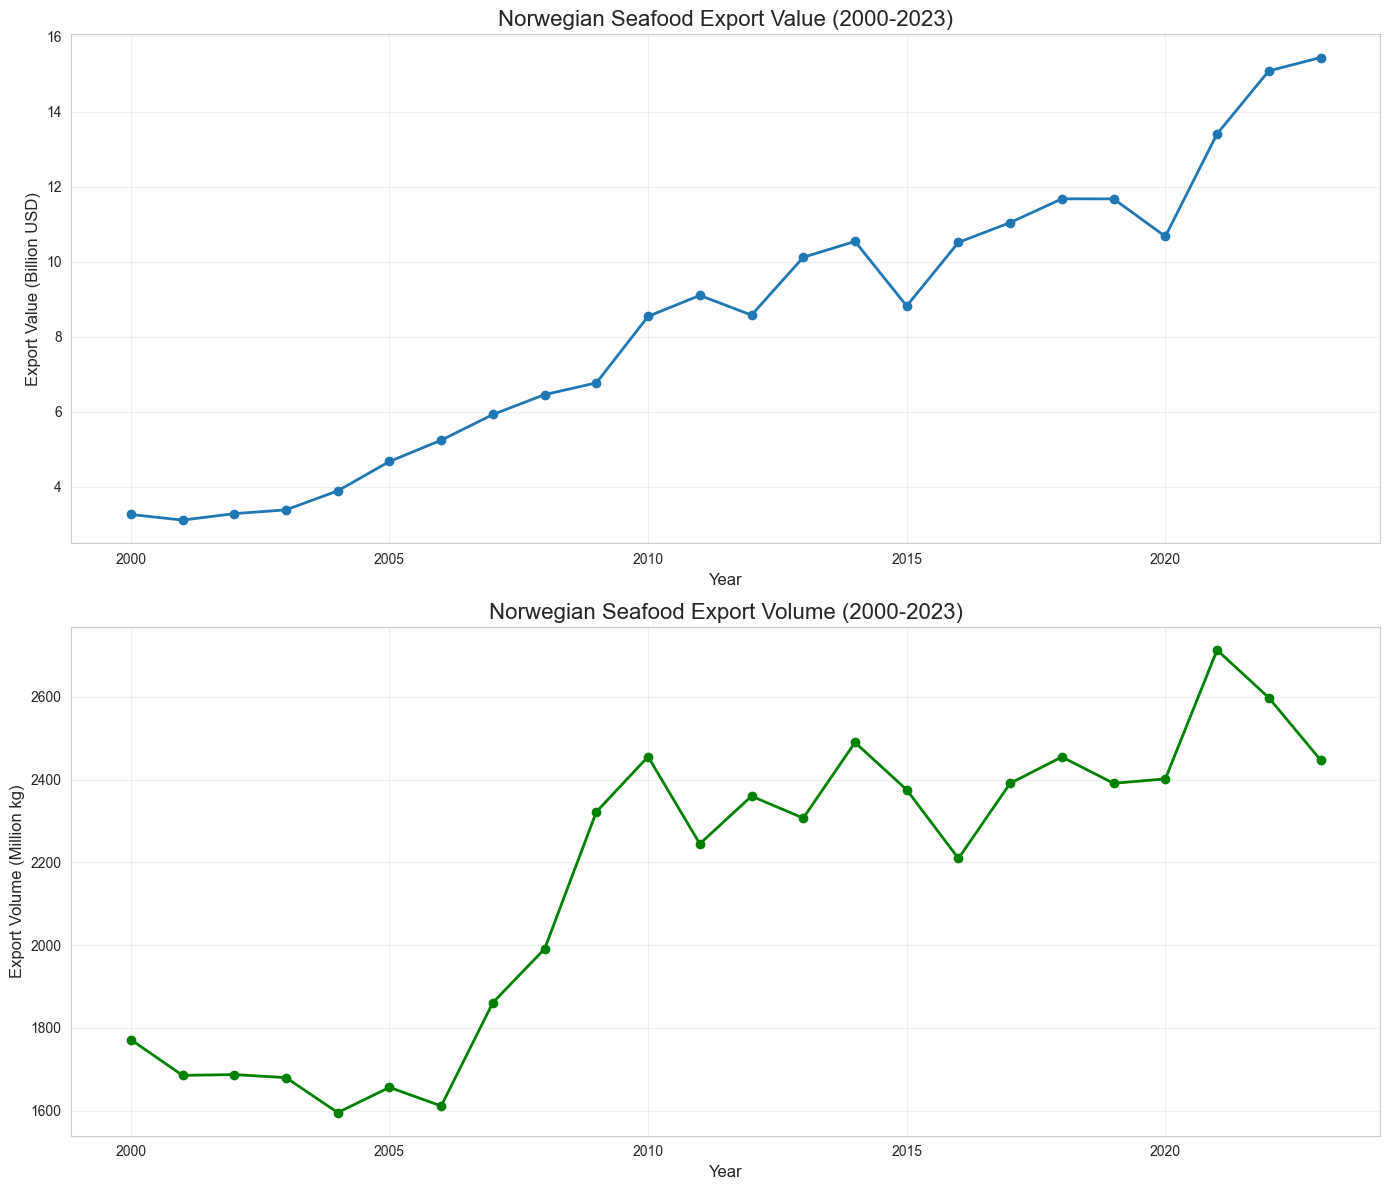

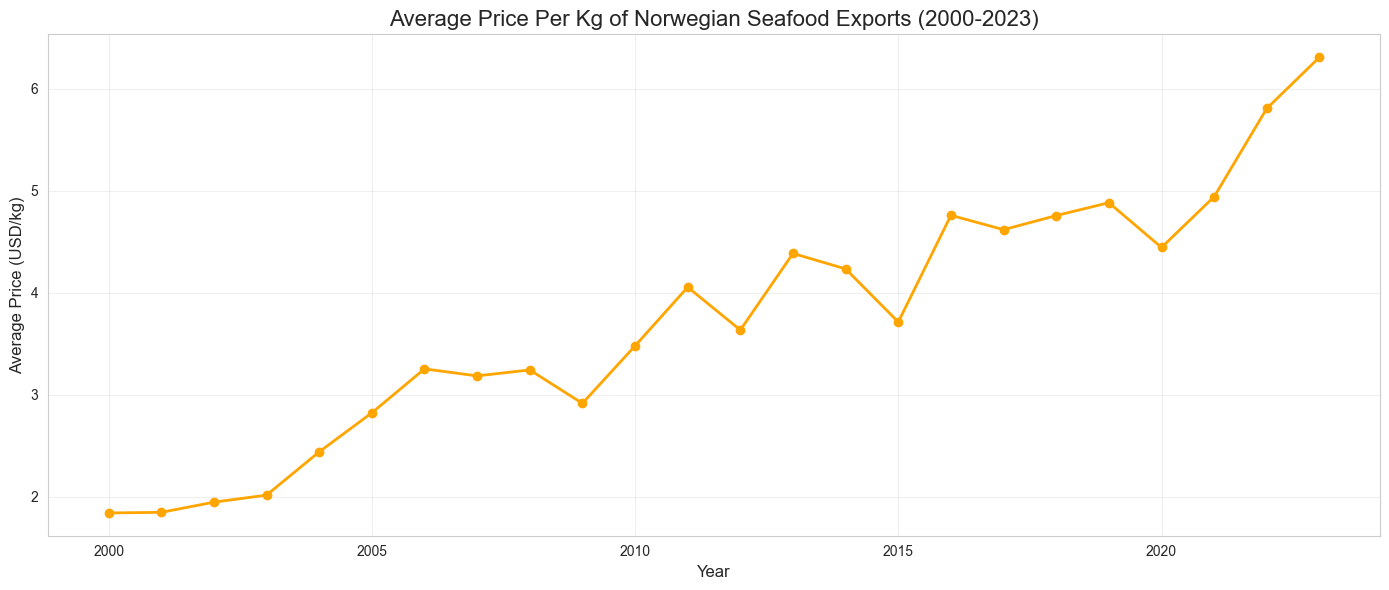

In [5]:
# Plot yearly export weight and value
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot total export value by year
axes[0].plot(yearly_exports['Year'], yearly_exports['Trade (USD)'] / 1e9, marker='o', linewidth=2)
axes[0].set_title('Norwegian Seafood Export Value (2000-2023)', fontsize=16)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Export Value (Billion USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot total export weight by year
axes[1].plot(yearly_exports['Year'], yearly_exports['Weight (kg)'] / 1e6, marker='o', linewidth=2, color='green')
axes[1].set_title('Norwegian Seafood Export Volume (2000-2023)', fontsize=16)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Export Volume (Million kg)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot average price per kg over time
plt.figure(figsize=(14, 6))
plt.plot(yearly_exports['Year'], yearly_exports['Avg_Price_Per_Kg'], marker='o', linewidth=2, color='orange')
plt.title('Average Price Per Kg of Norwegian Seafood Exports (2000-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (USD/kg)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analyzing Top Export Categories

Let's identify the top seafood export categories by weight and value.

In [6]:
# Group by commodity and calculate total exports for the entire period
commodity_exports = norway_exports.groupby('Commodity').agg({
    'Trade (USD)': 'sum',
    'Weight (kg)': 'sum'
}).reset_index()

# Get top 10 commodities by export value
top10_value = commodity_exports.sort_values('Trade (USD)', ascending=False).head(10)
print("Top 10 seafood exports by value:")
top10_value[['Commodity', 'Trade (USD)']]

# Get top 10 commodities by export weight
top10_weight = commodity_exports.sort_values('Weight (kg)', ascending=False).head(10)
print("\nTop 10 seafood exports by weight:")
top10_weight[['Commodity', 'Weight (kg)']]

Top 10 seafood exports by value:

Top 10 seafood exports by weight:


,Commodity,Weight (kg)
106,"Fish; fresh or chilled, Atlantic salmon (Salmo...",10760979349
232,Pacific salmon/Atlantic salmon/Danube salmon [...,5124785360
160,"Fish; frozen, herrings (Clupea harengus, Clupe...",3804570489
164,"Fish; frozen, mackerel (Scomber scombrus, Scom...",3588701024
207,Mackerel (Scomber scombrus/australasicus/japon...,2739724990
205,"Herrings (Clupea harengus/pallasii), frozen (e...",2395787715
90,"Fish meat, excluding fillets, whether or not m...",1536251549
111,"Fish; fresh or chilled, blue whitings (Microme...",1288098702
62,"Fish fillets; fresh or chilled, salmon, Pacifi...",1091803942
99,"Fish; dried, whether or not salted but not smo...",949234615


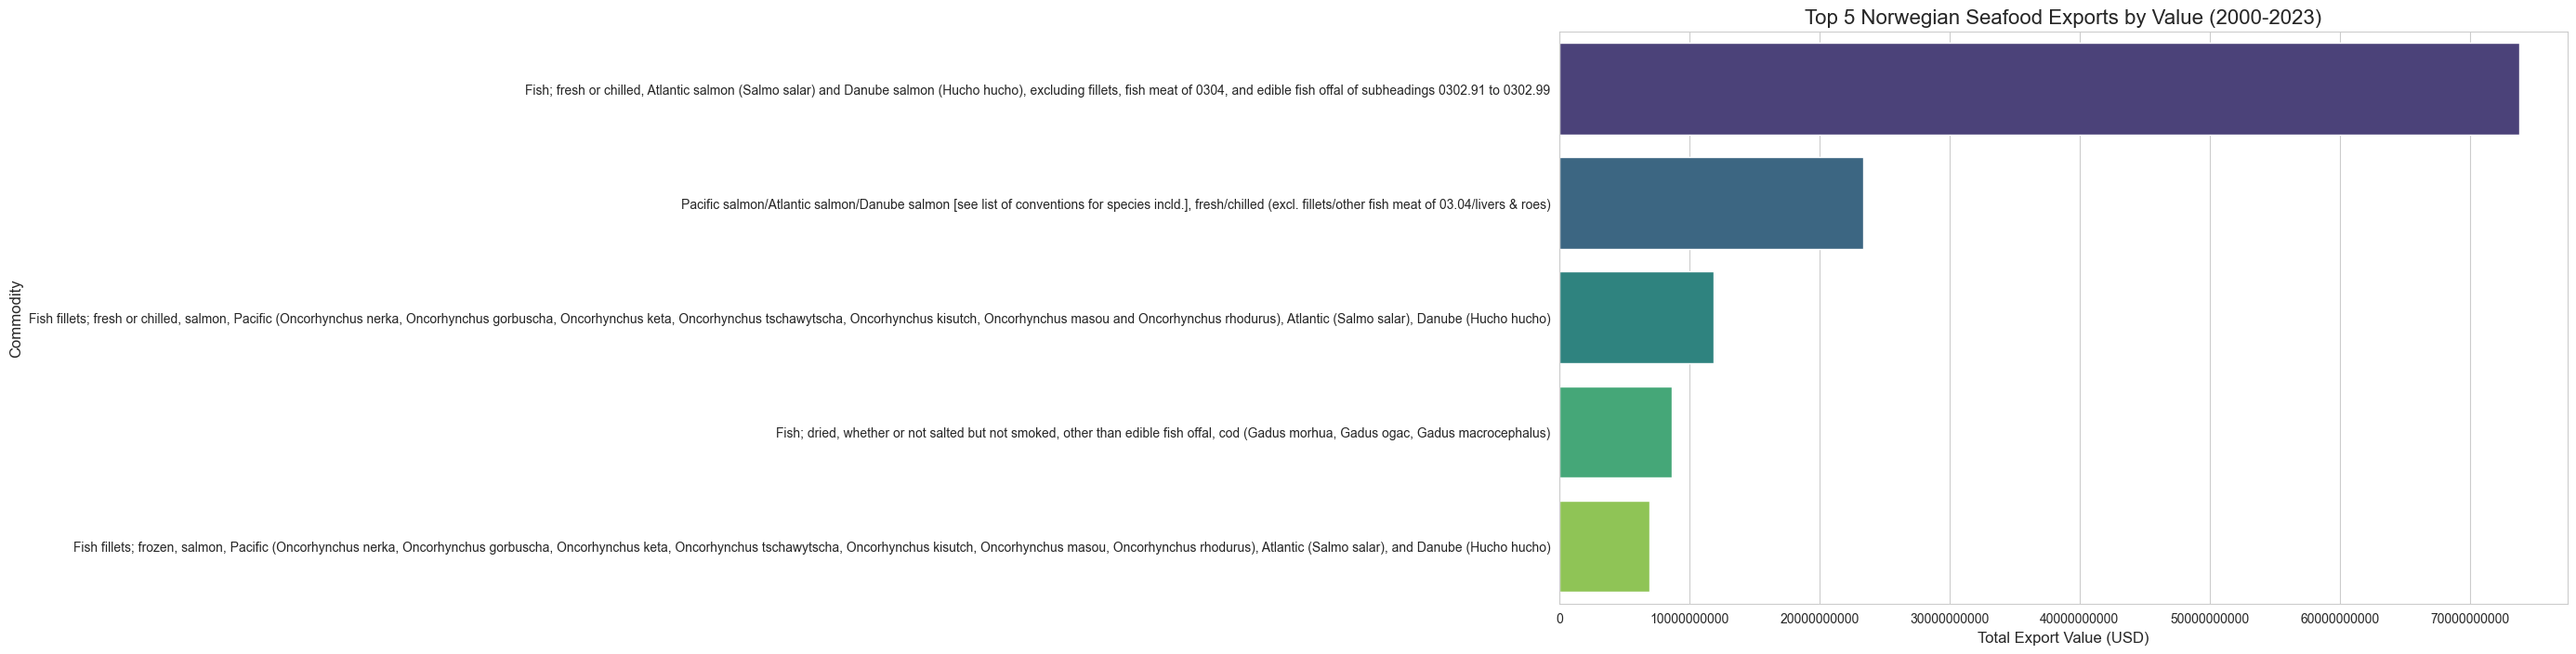

In [7]:
# Plotting top 5 commodities by value
plt.figure(figsize=(14, 8))
sns.barplot(x='Trade (USD)', y='Commodity', data=top10_value.head(5), palette='viridis')
plt.title('Top 5 Norwegian Seafood Exports by Value (2000-2023)', fontsize=16)
plt.xlabel('Total Export Value (USD)', fontsize=12)
plt.ylabel('Commodity', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()

### Time Series Analysis of Key Commodities

Let's focus on the key commodities and analyze their export trends over time.

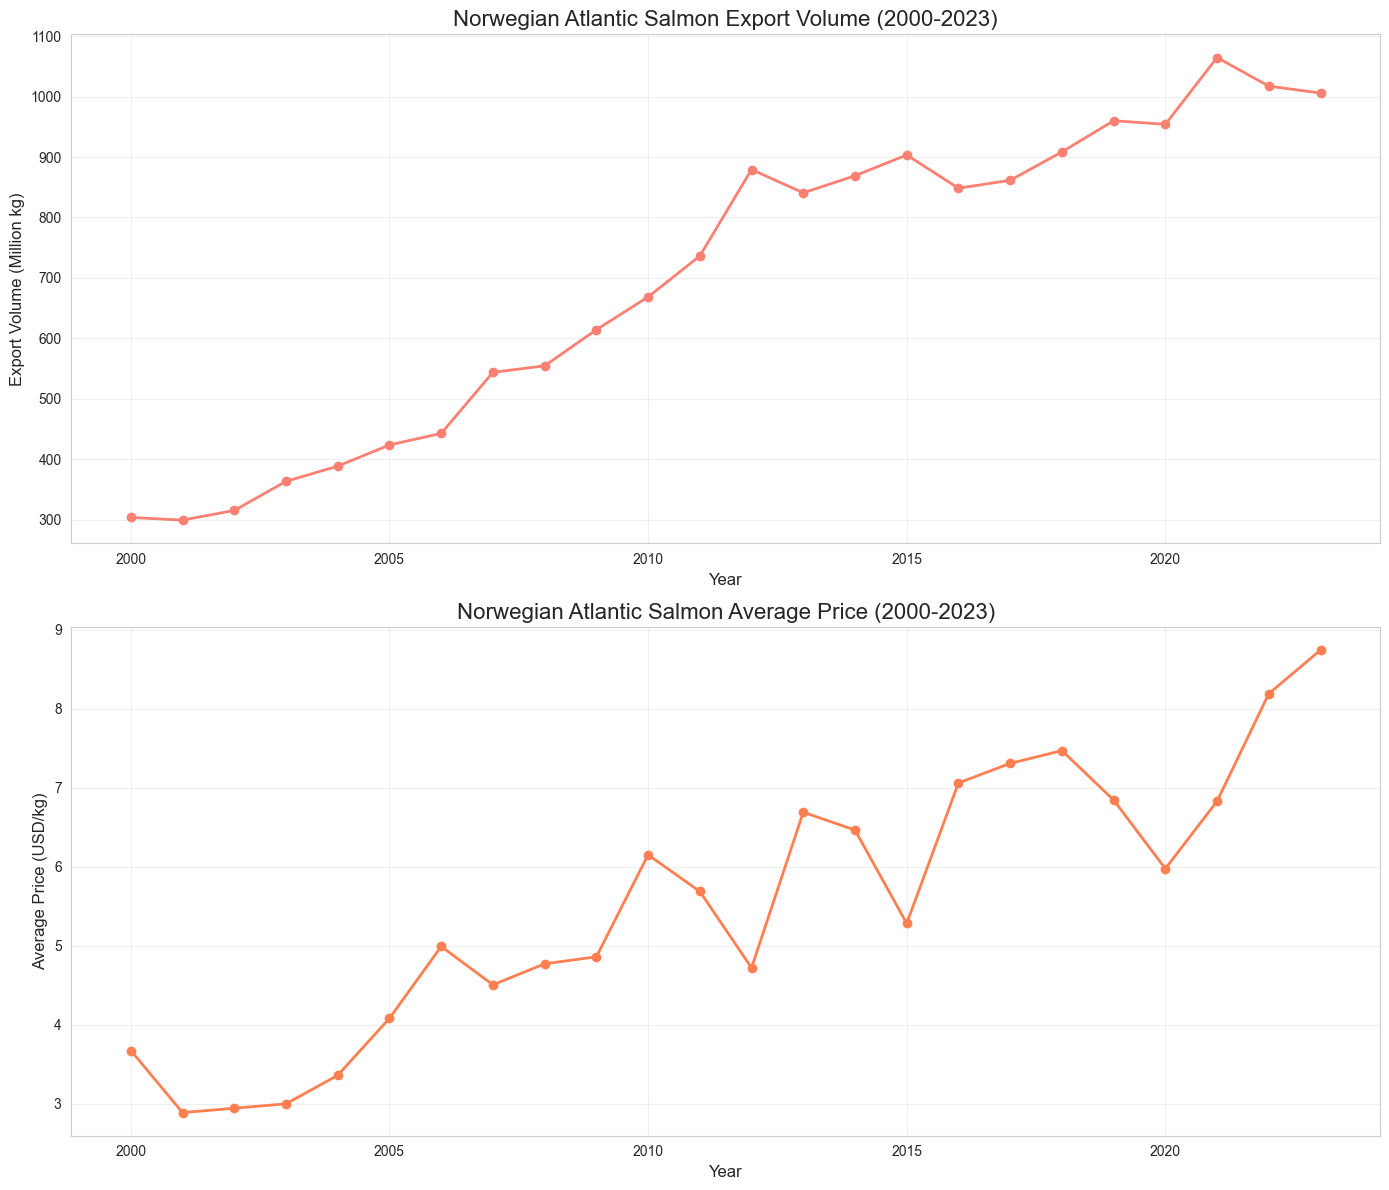

In [8]:
# Select a key commodity (Atlantic Salmon)
atlantic_salmon = norway_exports[norway_exports['Commodity'].str.contains('Atlantic salmon', case=False)]

# Group by year
salmon_yearly = atlantic_salmon.groupby('Year').agg({
    'Trade (USD)': 'sum',
    'Weight (kg)': 'sum'
}).reset_index()

# Calculate average price per kg
salmon_yearly['Avg_Price_Per_Kg'] = salmon_yearly['Trade (USD)'] / salmon_yearly['Weight (kg)']

# Plot salmon export trends
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].plot(salmon_yearly['Year'], salmon_yearly['Weight (kg)'] / 1e6, marker='o', linewidth=2, color='salmon')
axes[0].set_title('Norwegian Atlantic Salmon Export Volume (2000-2023)', fontsize=16)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Export Volume (Million kg)', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(salmon_yearly['Year'], salmon_yearly['Avg_Price_Per_Kg'], marker='o', linewidth=2, color='coral')
axes[1].set_title('Norwegian Atlantic Salmon Average Price (2000-2023)', fontsize=16)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Average Price (USD/kg)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Feature Engineering

Now, let's prepare the data for our machine learning models. We'll create features for predicting salmon export volume.

In [9]:
# Let's use Atlantic salmon data for our prediction models
salmon_data = salmon_yearly.copy()

# Create lag features (previous years' export volumes)
for i in range(1, 4):  # Create 3 lag features
    salmon_data[f'Weight_Lag_{i}'] = salmon_data['Weight (kg)'].shift(i)
    salmon_data[f'Price_Lag_{i}'] = salmon_data['Avg_Price_Per_Kg'].shift(i)

# Create rolling average features
salmon_data['Weight_Rolling_Mean_2'] = salmon_data['Weight (kg)'].rolling(window=2).mean().shift(1)
salmon_data['Price_Rolling_Mean_2'] = salmon_data['Avg_Price_Per_Kg'].rolling(window=2).mean().shift(1)

# Add year-over-year growth rate
salmon_data['Weight_YoY_Growth'] = salmon_data['Weight (kg)'].pct_change()
salmon_data['Price_YoY_Growth'] = salmon_data['Avg_Price_Per_Kg'].pct_change()

# Drop rows with NaN values (first 3 years due to lag features)
salmon_data = salmon_data.dropna().reset_index(drop=True)

# Display the prepared data
salmon_data.head()

,Year,Trade (USD),Weight (kg),Avg_Price_Per_Kg,Weight_Lag_1,Price_Lag_1,Weight_Lag_2,Price_Lag_2,Weight_Lag_3,Price_Lag_3,Weight_Rolling_Mean_2,Price_Rolling_Mean_2,Weight_YoY_Growth,Price_YoY_Growth
0,2003,1.090014e+09,363769621,2.996440,315607444.0,2.940473,299692906.0,2.885222,304023843.0,3.670925,307650175.0,2.912847,0.152602,0.019034
1,2004,1.305572e+09,388859052,3.357442,363769621.0,2.996440,315607444.0,2.940473,299692906.0,2.885222,339688532.5,2.968457,0.068971,0.120477
2,2005,1.729158e+09,423944051,4.078741,388859052.0,3.357442,363769621.0,2.996440,315607444.0,2.940473,376314336.5,3.176941,0.090225,0.214836
3,2006,2.210239e+09,443038645,4.988819,423944051.0,4.078741,388859052.0,3.357442,363769621.0,2.996440,406401551.5,3.718091,0.045040,0.223127
4,2007,2.449259e+09,543945735,4.502764,443038645.0,4.988819,423944051.0,4.078741,388859052.0,3.357442,433491348.0,4.533780,0.227761,-0.097429


In [10]:
# Define features and target variable
features = ['Weight_Lag_1', 'Weight_Lag_2', 'Weight_Lag_3', 'Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3',
            'Weight_Rolling_Mean_2', 'Price_Rolling_Mean_2', 'Weight_YoY_Growth', 'Price_YoY_Growth']
X = salmon_data[features]
y = salmon_data['Weight (kg)']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (16, 10)
Test set shape: (5, 10)


## 4. Model Training and Evaluation

Now we'll train multiple machine learning models and compare their performance.

In [11]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 50)
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

### 4.1 Linear Regression (Baseline Model)

In [12]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
lr_results = evaluate_model(y_test, lr_pred, "Linear Regression")

Linear Regression Performance:
Mean Squared Error (MSE): 539706369991437.69
Root Mean Squared Error (RMSE): 23231581.31
Mean Absolute Error (MAE): 18867655.31
R² Score: 0.9914
--------------------------------------------------


### 4.2 Random Forest Regression

In [13]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
rf_results = evaluate_model(y_test, rf_pred, "Random Forest")

Random Forest Performance:
Mean Squared Error (MSE): 3130273534323885.00
Root Mean Squared Error (RMSE): 55948847.48
Mean Absolute Error (MAE): 43881302.40
R² Score: 0.9503
--------------------------------------------------


### 4.3 Support Vector Regression (SVR)

In [14]:
# SVR model
svr_model = SVR(kernel='rbf', C=1000000000, gamma='auto')
svr_model.fit(X_train_scaled, y_train)

# Make predictions
svr_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
svr_results = evaluate_model(y_test, svr_pred, "Support Vector Regression")

Support Vector Regression Performance:
Mean Squared Error (MSE): 3411001522552665.50
Root Mean Squared Error (RMSE): 58403780.04
Mean Absolute Error (MAE): 44794736.02
R² Score: 0.9458
--------------------------------------------------


### 4.4 XGBoost Regression

In [19]:
# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_results = evaluate_model(y_test, xgb_pred, "XGBoost")

XGBoost Performance:
Mean Squared Error (MSE): 2480074521163904.00
Root Mean Squared Error (RMSE): 49800346.60
Mean Absolute Error (MAE): 44563750.60
R² Score: 0.9606
--------------------------------------------------


### 4.5 LSTM Neural Network for Time Series Forecasting

LSTM networks are particularly well-suited for time series forecasting. Let's adapt our data for LSTM.

In [20]:
# Prepare data for LSTM (reshape to [samples, time steps, features])
def create_lstm_dataset(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Convert to numpy arrays
X_arr = X.values
y_arr = y.values

# Scale all features
X_scaled = scaler.fit_transform(X_arr)

# Create sequences for LSTM
time_steps = 3
X_lstm, y_lstm = create_lstm_dataset(X_scaled, y_arr, time_steps)

# Split the data
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

print(f"LSTM data shape: {X_lstm.shape}")

LSTM data shape: (18, 3, 10)


In [32]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(500, return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(500),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_model.fit(
    X_train_lstm, y_train_lstm, 
    epochs=100, 
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

In [33]:
# Evaluate LSTM model
lstm_pred = lstm_model.predict(X_test_lstm, verbose=0)
lstm_results = evaluate_model(y_test_lstm, lstm_pred, "LSTM")

LSTM Performance:
Mean Squared Error (MSE): 1022312406379567872.00
Root Mean Squared Error (RMSE): 1011094657.48
Mean Absolute Error (MAE): 1010332654.29
R² Score: -662.6958
--------------------------------------------------


### 4.6 Auto Gluon - Automatic Machine learning approach

Auto Gluon is an open-source library for automating machine learning tasks. It can be used to quickly build and evaluate multiple models without extensive manual tuning. It is state-of-the-art in terms of performance and speed, making it a great choice for this task.

In [34]:
# AutoGluon Tabular Model
# concat X_train and y_train for AutoGluon
train_gluon = pd.concat([X_train, y_train], axis=1)
model = TabularPredictor(label='Weight (kg)', verbosity=0).fit(train_data=train_gluon, time_limit=100, presets='best_quality')
predictions = model.predict(data=X_test)
autogluon_results = evaluate_model(y_test, predictions, "AutoGluon Tabular Model")



2025-05-06 19:05:14,910	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


AutoGluon Tabular Model Performance:
Mean Squared Error (MSE): 4540689111974361.00
Root Mean Squared Error (RMSE): 67384635.58
Mean Absolute Error (MAE): 50429232.60
R² Score: 0.9279
--------------------------------------------------


## 5. Model Comparison

Let's compare the performance of all the models side by side.

In [35]:
# Combine all model results
all_results = pd.DataFrame([lr_results, rf_results, svr_results, xgb_results, autogluon_results])

# Display results in a table
all_results

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,5.397064e+14,2.323158e+07,1.886766e+07,0.991426
1,Random Forest,3.130274e+15,5.594885e+07,4.388130e+07,0.950270
2,Support Vector Regression,3.411002e+15,5.840378e+07,4.479474e+07,0.945810
3,XGBoost,2.480075e+15,4.980035e+07,4.456375e+07,0.960599
4,AutoGluon Tabular Model,4.540689e+15,6.738464e+07,5.042923e+07,0.927863


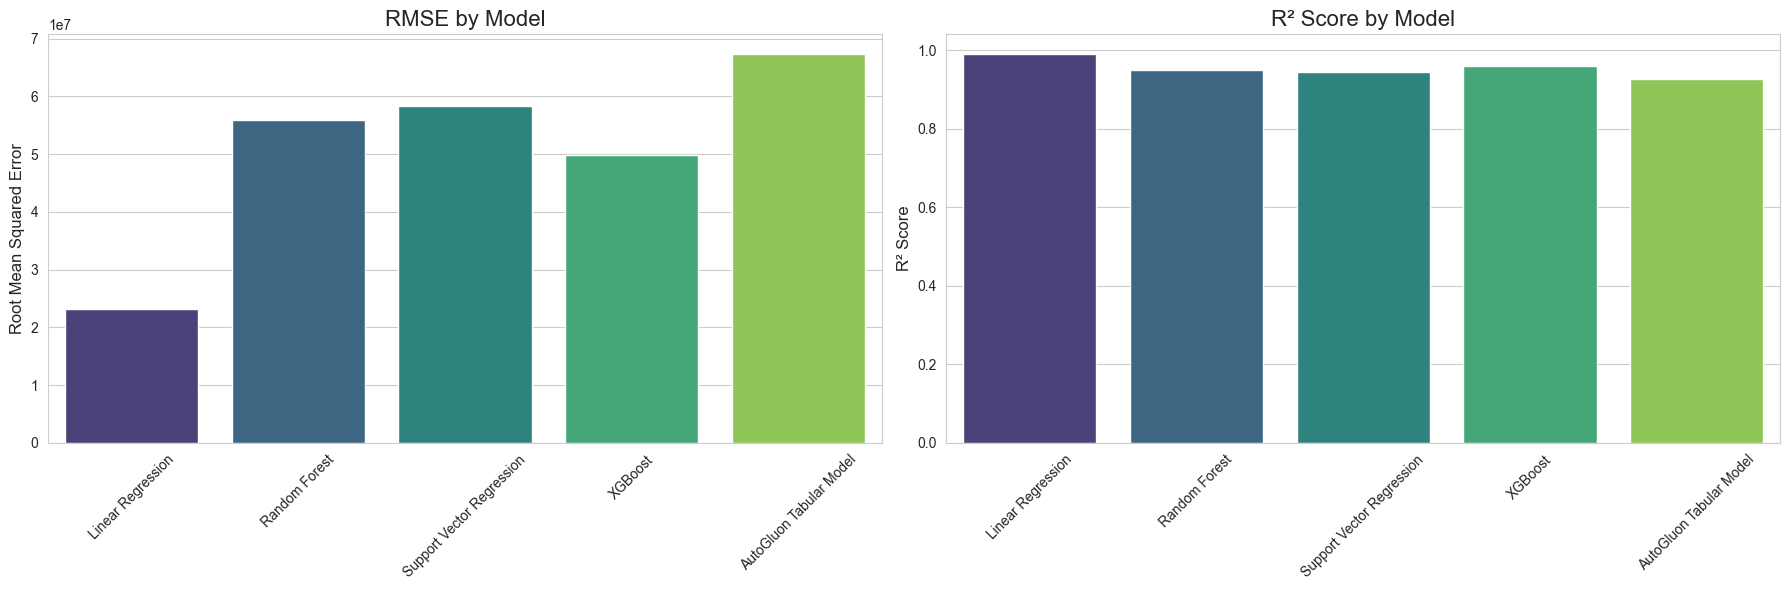

In [36]:
# Plot the RMSE and R² values for each model
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot RMSE (lower is better)
sns.barplot(x='Model', y='RMSE', data=all_results, ax=axes[0], palette='viridis')
axes[0].set_title('RMSE by Model', fontsize=16)
axes[0].set_ylabel('Root Mean Squared Error', fontsize=12)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Plot R² score (higher is better)
sns.barplot(x='Model', y='R2', data=all_results, ax=axes[1], palette='viridis')
axes[1].set_title('R² Score by Model', fontsize=16)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

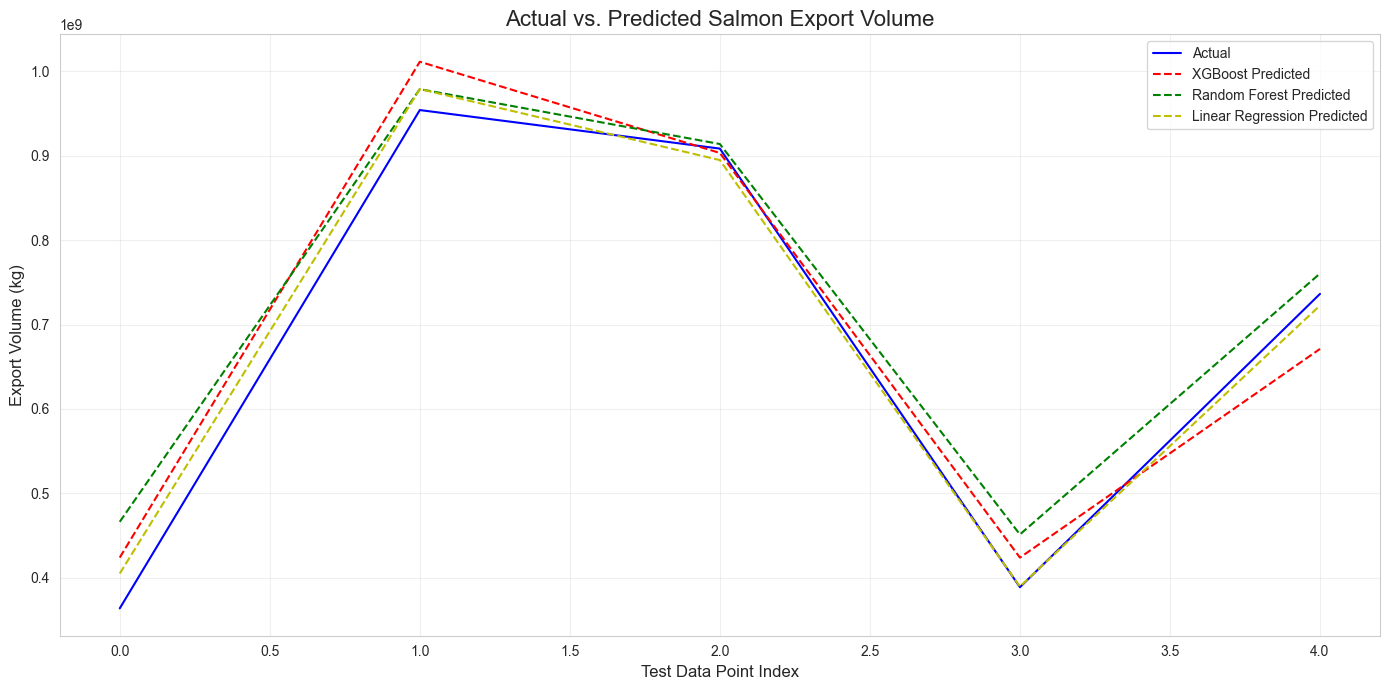

In [37]:
# Plot actual vs. predicted values for the best model (based on results)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, 'b-', label='Actual')
plt.plot(xgb_pred, 'r--', label='XGBoost Predicted')
plt.plot(rf_pred, 'g--', label='Random Forest Predicted')
plt.plot(lr_pred, 'y--', label='Linear Regression Predicted')
plt.title('Actual vs. Predicted Salmon Export Volume', fontsize=16)
plt.xlabel('Test Data Point Index', fontsize=12)
plt.ylabel('Export Volume (kg)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Let's examine which features are most influential in the XGBoost model.

In [38]:
# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# normalize the importance values and round to 6 decimal places
feature_importance['Importance'] = feature_importance['Importance'].round(6)
feature_importance['Importance'] = feature_importance['Importance'] / feature_importance['Importance'].sum()

# Display feature importance values
feature_importance

,Feature,Importance
0,Weight_Lag_1,0.933364
5,Price_Lag_3,0.029053
7,Price_Rolling_Mean_2,0.029020
8,Weight_YoY_Growth,0.006181
3,Price_Lag_1,0.001188
4,Price_Lag_2,0.001007
1,Weight_Lag_2,0.000186
9,Price_YoY_Growth,0.000001
2,Weight_Lag_3,0.000000
6,Weight_Rolling_Mean_2,0.000000


In [ ]:
# feature importance of our linear regression model
lr_coef = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)
# Normalize coefficients for better comparison
lr_coef['Normalized_Coefficient'] = lr_coef['Coefficient'] / np.abs(lr_coef['Coefficient']).sum()
lr_coef

,Feature,Coefficient,Normalized_Coefficient
0,Weight_Lag_1,1.620390e+08,0.474113
6,Weight_Rolling_Mean_2,7.359777e+07,0.215341
8,Weight_YoY_Growth,5.043377e+07,0.147565
4,Price_Lag_2,1.105248e+07,0.032339
5,Price_Lag_3,7.009713e+06,0.020510
7,Price_Rolling_Mean_2,-8.533972e+05,-0.002497
2,Weight_Lag_3,-5.364474e+06,-0.015696
9,Price_YoY_Growth,-7.161324e+06,-0.020953
1,Weight_Lag_2,-1.201889e+07,-0.035166
3,Price_Lag_1,-1.224218e+07,-0.035820


2025-05-06 19:06:58,284	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-05-06 19:06:58,284	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-05-06 19:06:58,292	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-05-06 19:06:58,298	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


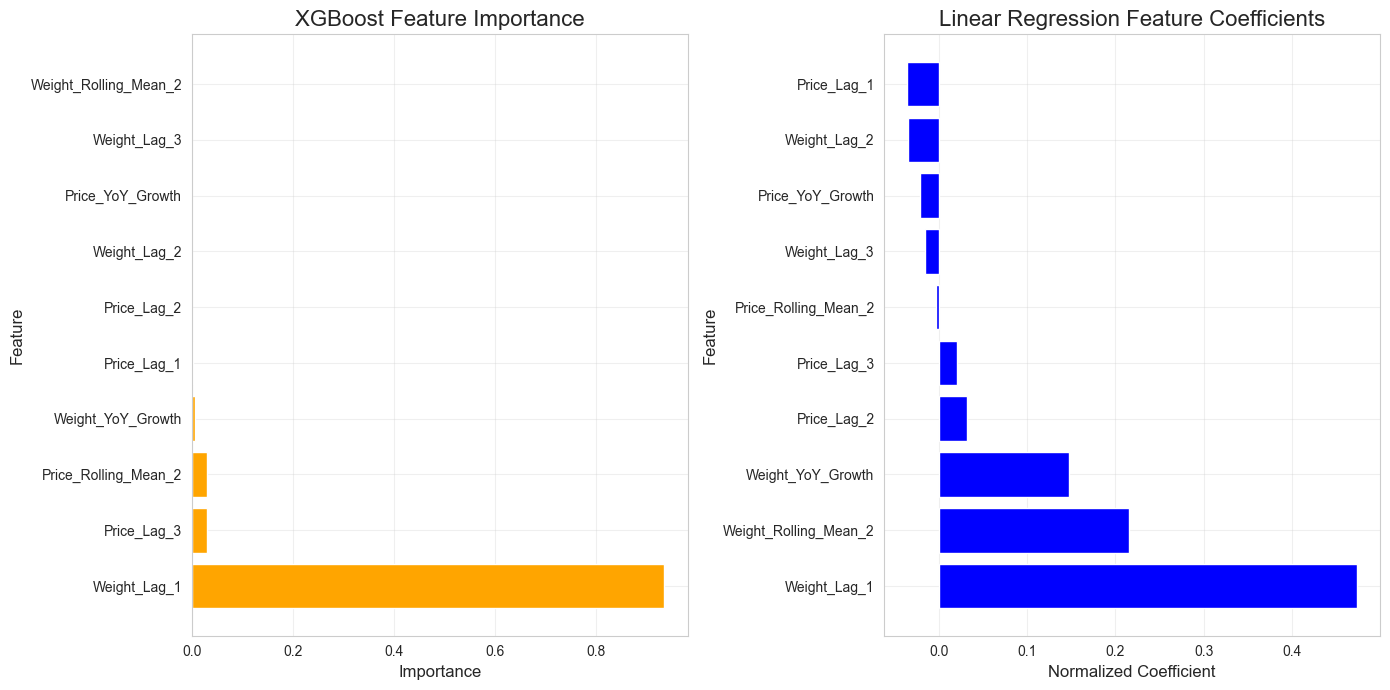

In [131]:
# Plot feature importance for XGBooost and Linear Regression
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='orange')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.barh(lr_coef['Feature'], lr_coef['Normalized_Coefficient'], color='blue')
plt.title('Linear Regression Feature Coefficients', fontsize=16)
plt.xlabel('Normalized Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Future Forecasting

Let's use our best-performing model to forecast future salmon export volumes.

In [122]:
# Prepare the most recent data for forecasting
last_data = salmon_data.iloc[-1:].copy()
forecast_years = 5  # Forecast for the next 5 years
forecast_results = []

# Store the actual last year's data
last_year = last_data['Year'].values[0]
last_weight = last_data['Weight (kg)'].values[0]
last_price = last_data['Avg_Price_Per_Kg'].values[0]

current_data = last_data.copy()

for i in range(forecast_years):
    # Extract features for prediction
    forecast_features = current_data[features].values
    forecast_features_scaled = scaler.transform(forecast_features)
    
    # Make prediction using XGBoost (our best model)
    weight_forecast = xgb_model.predict(forecast_features_scaled)[0]
    
    # Estimate price (simple heuristic based on historical trends)
    price_forecast = current_data['Avg_Price_Per_Kg'].values[0] * 1.05  # Assume 5% annual price increase
    
    # Store forecast
    forecast_year = last_year + i + 1
    forecast_results.append({
        'Year': forecast_year,
        'Forecasted_Weight_kg': weight_forecast,
        'Forecasted_Price_USD_per_kg': price_forecast
    })
    
    # Update current data for next iteration
    new_row = current_data.copy()
    new_row['Year'] = forecast_year
    new_row['Weight (kg)'] = weight_forecast
    new_row['Avg_Price_Per_Kg'] = price_forecast
    
    # Update lag features
    new_row['Weight_Lag_1'] = current_data['Weight (kg)'].values[0]
    new_row['Weight_Lag_2'] = current_data['Weight_Lag_1'].values[0]
    new_row['Weight_Lag_3'] = current_data['Weight_Lag_2'].values[0]
    new_row['Price_Lag_1'] = current_data['Avg_Price_Per_Kg'].values[0]
    new_row['Price_Lag_2'] = current_data['Price_Lag_1'].values[0]
    new_row['Price_Lag_3'] = current_data['Price_Lag_2'].values[0]
    
    # Update rolling means
    new_row['Weight_Rolling_Mean_2'] = (current_data['Weight (kg)'].values[0] + current_data['Weight_Lag_1'].values[0]) / 2
    new_row['Price_Rolling_Mean_2'] = (current_data['Avg_Price_Per_Kg'].values[0] + current_data['Price_Lag_1'].values[0]) / 2
    
    # Update growth rates
    new_row['Weight_YoY_Growth'] = (weight_forecast - current_data['Weight (kg)'].values[0]) / current_data['Weight (kg)'].values[0]
    new_row['Price_YoY_Growth'] = (price_forecast - current_data['Avg_Price_Per_Kg'].values[0]) / current_data['Avg_Price_Per_Kg'].values[0]
    
    current_data = new_row.copy()

# Convert forecast results to DataFrame
forecast_df = pd.DataFrame(forecast_results)
forecast_df

,Year,Forecasted_Weight_kg,Forecasted_Price_USD_per_kg
0,2024,1.005720e+09,9.178289
1,2025,1.011232e+09,9.637203
2,2026,1.064414e+09,10.119063
3,2027,1.064414e+09,10.625017
4,2028,1.064414e+09,11.156267


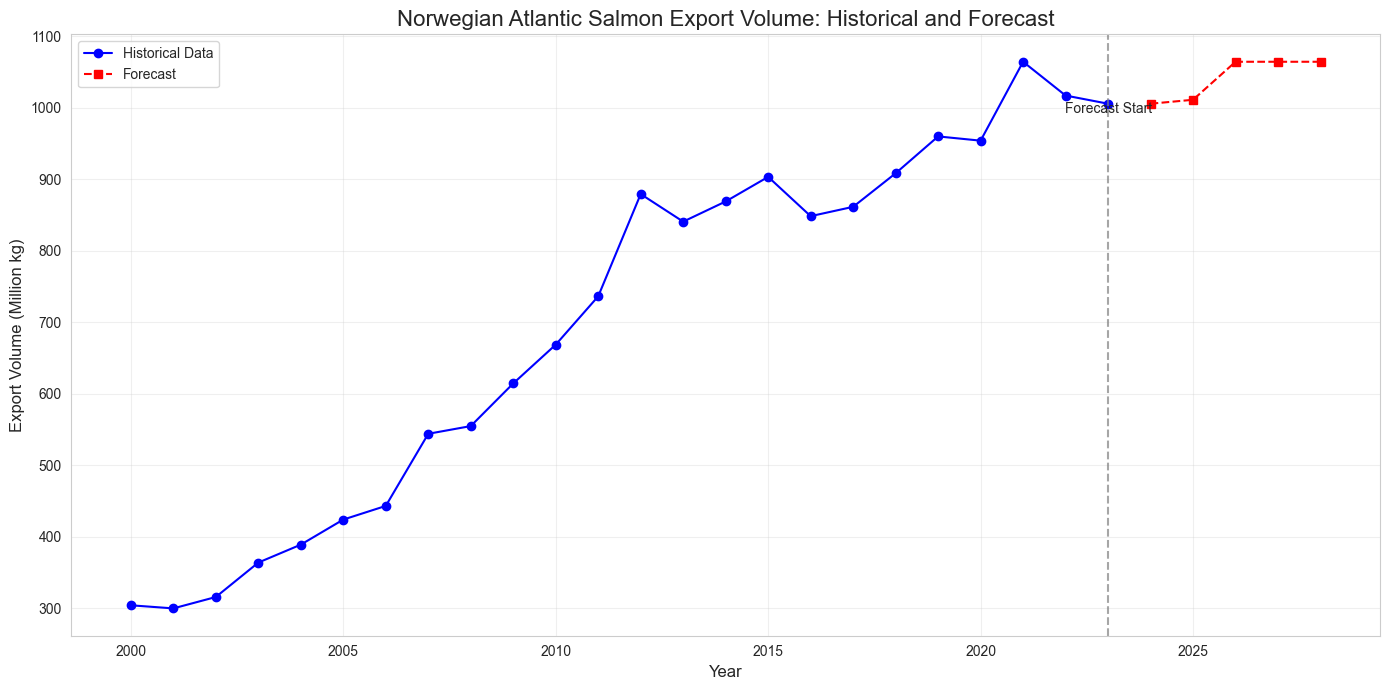

In [123]:
# Plot historical data and forecast
plt.figure(figsize=(14, 7))

# Historical data
plt.plot(salmon_yearly['Year'], salmon_yearly['Weight (kg)'] / 1e6, 'b-', marker='o', label='Historical Data')

# Forecast data
plt.plot(forecast_df['Year'], forecast_df['Forecasted_Weight_kg'] / 1e6, 'r--', marker='s', label='Forecast')

plt.axvline(x=last_year, color='gray', linestyle='--', alpha=0.7)
plt.text(last_year, plt.ylim()[1]*0.9, 'Forecast Start', horizontalalignment='center')

plt.title('Norwegian Atlantic Salmon Export Volume: Historical and Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Export Volume (Million kg)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Conclusions

In this notebook, we compared various machine learning models for predicting seafood demand using Norwegian export data from 2000-2023. Our analysis did not agree with the findings of the paper "Advanced Machine Learning for Fish Price Prediction Using an XGBoost Approach" https://fisheries-2023.sites.olt.ubc.ca/files/2024/09/2024-01-Working-Paper-Price-Prediction.pdf which said quote:  "Results show that XGBoost outperforms other models, providing a reliable tool for anticipating price changes and supporting informed decision-making in the fisheries sector." We found that XGBoost performed good, but worse than linear regression and slightly better/equal to random forrest.

### Key Findings with regards to model comparison:

**Feature importance**: The most influential factors for predicting salmon export volume were by far the previous year's export volume in kg with a 93% importance score. XGBoost relying almost solely on one feature compared to linear regression which relied on more features in its prediction might explain why it performance did not meet expectations.
**Data sparsity**: The dataset we used in this experiemenent is quite sparse, which I am guessing is why linear regression performed best as the ML-algorithms might have overfitted to the training data. The experiment could have involved even more datapoints, like   weekly or monthly export numbers rather than just yearly data. This might have allowed us to capture more seasonal trends and fluctuations in demand, and more sophisticated models could have performed better. It is also important to note that this is just one type of dataset representing seafood demand and different ML models might perform better on different datasets.
**Model parameters**: Both our choice of models and their respective hyperparameters may not be optimal as we just wanted a simple experiement. Hence the comparison might be quite invalid.

### Implications for the Seafood Industry:

These models have showed their effectivness in helping us predict future demand for seafood products while doing it 



